In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from src.nflow_utils import *


In [2]:
from nflows import transforms, distributions, flows
import torch
import torch.nn.functional as F
from nflows.distributions import uniform


In [ ]:
#os.environ["CUDA_VISIBLE_DEVICES"]='2'


CUDA = True
device = torch.device("cuda:0" if CUDA else "cpu")

kwargs = {'num_workers': 4, 'pin_memory': True} if CUDA else {}
kwargs = {}


In [3]:
import pickle

with open('../data/data_2d.pkl','rb') as f:
    data = pickle.load(f)

with open('../data/true_w_2d.pkl','rb') as f:
    true_w = pickle.load(f)

In [4]:
sig_sigma = 0.25
sig_mean = 2
back_mean = 0
back_sigma = 3

In [5]:
w_ = true_w['10'][0]

In [6]:
data_ = data['10']['val']['data']
label_ = data['10']['val']['label']
#label_ = 1-label_

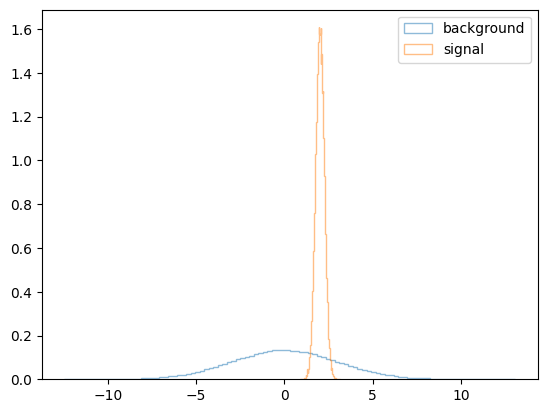

In [8]:
plt.hist(data_[label_==0][:,1], bins=100, alpha=0.5, histtype='step', label='background', density=True)
plt.hist(data_[label_==1][:,1], bins=100, alpha=0.5, histtype='step', label='signal', density=True)
plt.legend()
plt.show()

In [15]:
def p_data(data,mu,sigma,p,dim=1):

    """ 2 gaussian mixture model"""
    p_c1 = 1.0
    p_c2 = 1.0

    print('mu', mu)
    print('sigma', sigma)
    print(data.shape)
    
    for d in range(dim):
        p_c1 *= norm.pdf(data[:,d], mu[0], sigma[0])

    for d in range(dim):
        p_c2 *= norm.pdf(data[:,d], mu[1], sigma[1])

    return p[0]*(p_c1) + p[1]*(p_c2)

def p_back(data,mu,sigma,dim=1):

    """ background gaussian """
    pc = 1.0
    print('mu', mu)
    print('sigma', sigma)
    for d in range(dim):
        pc *= norm.pdf(data[:,d], mu,sigma)

    return pc

In [7]:
data_p = p_data(data_,[sig_mean, back_mean],[sig_sigma,back_sigma],
                [w_, 1-w_], dim=2)
#back_p = p_back(data_,back_mean, back_sigma, dim=2)

In [7]:
from sklearn.model_selection import ShuffleSplit

In [8]:
shuffle_split = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

In [12]:
for train, val in shuffle_split.split(data_, label_):
    data_train = data_[train]
    data_val = data_[val]
    print(data_train[0:20])

[[ 2.21023224 -5.15802605]
 [ 4.54013893  4.57280163]
 [ 3.09959381  2.8895487 ]
 [ 2.48013799  2.32648868]
 [-0.56282119  4.20969567]
 [ 2.15113231  1.70037414]
 [ 0.19642975  0.43833637]
 [-0.2580104  -4.77207014]
 [ 1.96267534  1.94335251]
 [-5.25727805  1.84582057]
 [ 2.30783033  1.86187376]
 [ 1.89676579  0.25985927]
 [-2.22225255  4.0143293 ]
 [ 1.39047369  1.67737235]
 [-2.15420164 -2.83698704]
 [-3.64543293 -1.77024597]
 [-0.27979051 -4.38982396]
 [-0.51211967  3.10791019]
 [-2.13596876  3.08998408]
 [-0.20361599  2.00569089]]
[[ 6.36070988  3.65095922]
 [-2.96638664  2.1464416 ]
 [ 3.89658683 -0.99778886]
 [ 4.44406188 -1.98226054]
 [ 3.8277377  -3.43256335]
 [-4.41364783  4.75708852]
 [-0.452913   -1.31548606]
 [-1.25225865  0.6790395 ]
 [ 1.84651004  2.23160489]
 [ 2.09782942 -0.43732785]
 [ 1.8689535   1.85769757]
 [ 5.36248275 -2.06589969]
 [-6.18701081  2.1542366 ]
 [ 2.12889522  2.24467507]
 [-2.21514181 -0.77712474]
 [ 1.95460361  1.82230196]
 [-3.08739106 -4.04438073]


In [9]:
model_S = gaussian_prob(sig_mean, sig_sigma, dim=2)
model_B = gaussian_prob(back_mean, back_sigma, dim=2)

In [15]:
w_* np.exp(model_S.log_prob(torch.tensor(data_)).numpy()) + \
(1-w_) * np.exp(model_B.log_prob(torch.tensor(data_)).numpy())

array([-4.33592236, -4.41438434, -4.45074387, ..., -6.99441828,
       -5.95669318, -5.48012242])

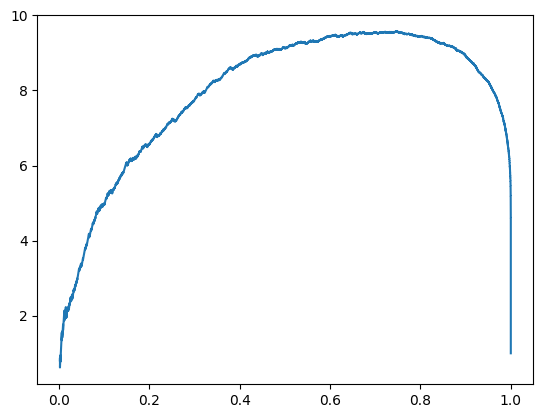

In [18]:
sic, tpr , auc = SIC(label_, data_p/back_p)

plt.plot(tpr, sic, label='true: auc = {:.3f}'.format(auc))
plt.show()

In [4]:
CRdata=np.random.normal(scale=1,loc=0,size=100000)
SRdata=np.concatenate((np.random.normal(scale=1,loc=0,size=50000),np.random.normal(scale=1,loc=3,size=50000)))
np.random.shuffle(SRdata)

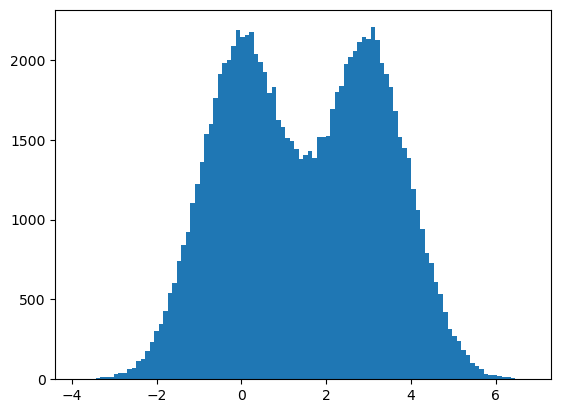

In [5]:
_=plt.hist(SRdata,bins=100)

In [6]:
traintensor = torch.from_numpy(SRdata[:90000].astype('float32').reshape((-1,1)))
#traindataset = torch.utils.data.TensorDataset(traintensor)

valtensor = torch.from_numpy(SRdata[90000:].astype('float32').reshape((-1,1)))
#valdataset = torch.utils.data.TensorDataset(valtensor)

In [7]:
len(SRdata)

100000

In [8]:
# Use the standard pytorch DataLoader
batch_size = 256
#batch_size = 256
trainloader = torch.utils.data.DataLoader(traintensor, batch_size=batch_size, shuffle=True)


In [9]:
test_batch_size=batch_size*5
valloader = torch.utils.data.DataLoader(valtensor, batch_size=test_batch_size, shuffle=False)


In [10]:
model=define_model(nfeatures=1,nhidden=2,hidden_size=20,embedding=None,dropout=0,nembedding=0)


In [11]:
# train
valloss_list=[]
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4) #,lr=1e-4)#, lr=1e-4)

for epoch in range(2):
    print('\n Epoch: {}'.format(epoch))
    train(model,optimizer,trainloader,noise_data=0.,noise_context=0.0)
    valloss=val(model,valloader)
    print('epoch '+str(epoch)+' val loss: ',valloss)
#    torch.save(model.state_dict(),"babydataset_fLDeltaf0.01_epoch_"+str(epoch)+"_Model.par")
    valloss_list.append(valloss)
    
    

 




 Epoch: 0
epoch 0 val loss:  1.956383203125

 Epoch: 1
epoch 1 val loss:  1.9546015625

 Epoch: 2
epoch 2 val loss:  1.9536119140625

 Epoch: 3
epoch 3 val loss:  1.954163671875

 Epoch: 4
epoch 4 val loss:  1.9559248046875

 Epoch: 5
epoch 5 val loss:  1.953825390625

 Epoch: 6
epoch 6 val loss:  1.9536728515625

 Epoch: 7
epoch 7 val loss:  1.9539892578125

 Epoch: 8
epoch 8 val loss:  1.9540080078125

 Epoch: 9
epoch 9 val loss:  1.9547755859375

 Epoch: 10
epoch 10 val loss:  1.9540123046875

 Epoch: 11
epoch 11 val loss:  1.954619140625

 Epoch: 12
epoch 12 val loss:  1.9531015625

 Epoch: 13
epoch 13 val loss:  1.9544060546875

 Epoch: 14
epoch 14 val loss:  1.9540078125

 Epoch: 15
epoch 15 val loss:  1.9541884765625

 Epoch: 16
epoch 16 val loss:  1.95457265625

 Epoch: 17
epoch 17 val loss:  1.953153125

 Epoch: 18
epoch 18 val loss:  1.95331796875

 Epoch: 19
epoch 19 val loss:  1.953458203125

 Epoch: 20
epoch 20 val loss:  1.953416015625

 Epoch: 21
epoch 21 val loss:  1.9

KeyboardInterrupt: 

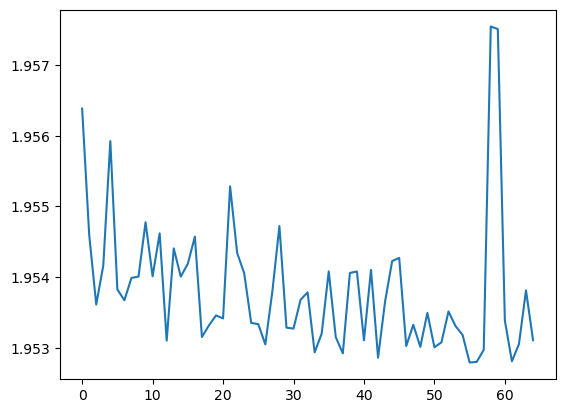

In [19]:
plt.plot(valloss_list)
plt.show()

In [14]:
model.eval()
with torch.no_grad():
    samples=model.sample(50000)
samples=samples.cpu().detach().numpy().reshape((-1))

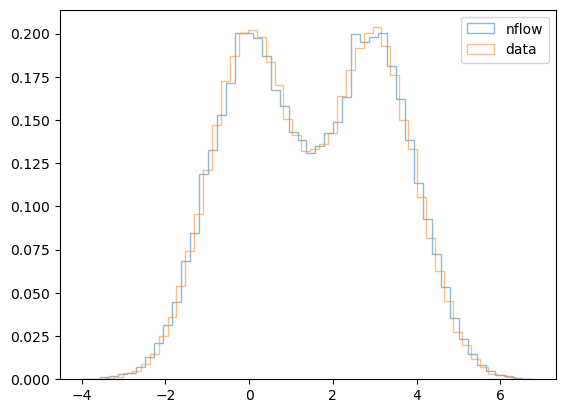

In [17]:
_=plt.hist(samples,bins=50, density=True, alpha=0.5, histtype='step', label='nflow')
_=plt.hist(SRdata,bins=50, density=True, alpha=0.5, histtype='step', label='data')
plt.legend(loc='upper right')
plt.show()